# Validate the Morphospace
Use the perturbation vectors to see how the individual drug perturbations affected the morphological space of MCF10A cells  
1.) Check cellular intrinsic fluctuation (DMSO morphological fluctuation)  
2.) Make PCA of drug treatments  
3.) Check replicate similarity  
4.) Check similarity for same MOAs  
5.) Check similarity with same ATC  
6.) Check similarity in dependence of PPI distance  

In [4]:
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
import random
import networkx as nx
from decimal import Decimal
import seaborn as sns

cm = plt.cm.get_cmap('tab20')

#%matplotlib inline

In [5]:
# Effect size
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)

## Check cellular intrinsic fluctuation 
Check DMSO treated cells to see how much per pure chance cells can change morphologically e.g. technical errors

In [6]:
# open file that contains feature vectors
path = '../data/Validate_Morphospace/All_Vectors_Combined.csv'
fp = open(path)
#fp.next()

features = fp.readline().split(',')[1:]
numfeatures = len(features)

# -----------------------------------------------------------
# extract vector lengths (norm) from file and collect them in a list (AllVectorvalues)
# extract DMSO vectors for the two batches separate (DMSO_Vectors_Batch1,DMSO_Vectors_Batch2)
# extract actual all individual vectors (Vector_Dictionary); contains all vectors i.e. singles, combinations, DMSO, PosCon
# extract all single vectors (drug_replicates), with a list of the individual replicates (7/6 per batch1/2)
# get a list of all perturbations i.e. singles and combinations but not DMSO/PosCon (all_Perturbations)
# -----------------------------------------------------------


#lists as described above
AllVectorvalues = []
DMSO_Wells = []
DMSO_Vectors_Batch1 = []
DMSO_Vectors_Batch2 = []
Vector_Dictionary = {}
drug_replicates = {}
all_Perturbations = []

#go through the vector file and assign all vectors correctly
for line in fp:
    tmp = line.strip().split(',')
    
    drug1, drug2 = tmp[0].split('_')[0].split('|')
    plate = tmp[0].split('_')[2]
    
    values = list(np.float_(tmp[1:]))
    vector_size = np.linalg.norm(values)
    
    
    
    #split here the DMSO wells into the two batches
    if drug1 == 'DMSO':
        DMSO_Wells.append(vector_size)
        if int(plate) < 1315065:
            DMSO_Vectors_Batch1.append(values)
        else:
            DMSO_Vectors_Batch2.append(values)
    
            
    #add vector length (norm) and actual vectors
    AllVectorvalues.append(vector_size)
    Vector_Dictionary[tmp[0]] = values
        
    #keep individual drug replicates
    if drug2 == 'DMSO':
        if drug_replicates.has_key(drug1):
            drug_replicates[drug1].append(values)
        else:
            drug_replicates[drug1] = [values]
    
    #keep the overall perturbations
    if drug1 != 'DMSO' and drug1 != 'PosCon':
        all_Perturbations.append(values)
    
fp.close()

## Make heatmap of all treatments

33020


KeyboardInterrupt: 

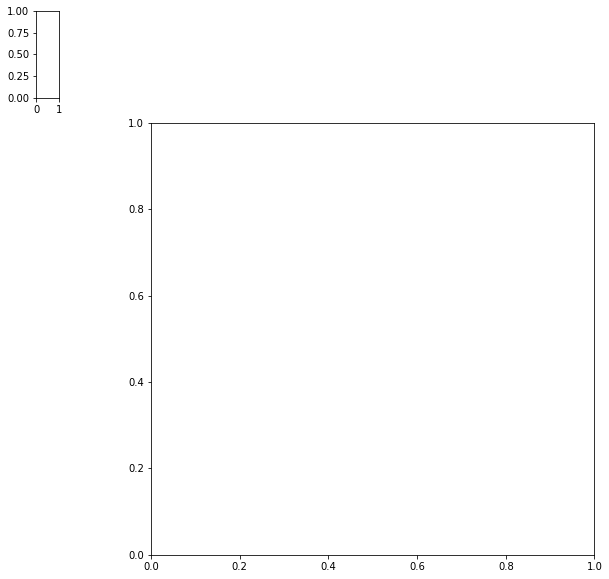

In [53]:
#extract all the drug perturbations
vectorsToPlot = []
for key in Vector_Dictionary.keys():
    treatment = key.split('_')[0].split('|')
    #vector_size = np.linalg.norm(Vector_Dictionary[key])
    
    #do not include DMSO or PosCon o
    if 'DMSO' in  treatment[0] or 'PosCon' in  treatment[0]:
        continue
    
    vectorsToPlot.append(Vector_Dictionary[key])

#create an SNS clustermap plot with the drug perturbations
print len(vectorsToPlot)
sns.clustermap(vectorsToPlot, cmap='RdBu_r', metric='euclidean', method ='average')
plt.savefig('../results/Validate_Morphospace/AllPerturationVectorsClusterMap_OnlySignificantEuclidean.pdf', dpi = 1200)
#plt.show()
plt.close()

## Load significance for single perturbations
see of 9_Calculate_Interactions

In [11]:
#set a significance threshold for 
perturbaion_significnace = 7

#save the max. mahalanobis distance over the two batches
drug_perturbation_significances = {}

number_valid_drugs = 0
#Open file containing the mahalanobis distance of the single perturbations
fp = open('../data/Validate_Morphospace/Singles_Significance.csv')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    #print tmp
    values = []
    if tmp[1] != "No_Cells":
        value1 = float(tmp[1])
        values.append(value1)
    
    if tmp[3] != "No_Cells":
        value1 = float(tmp[3])
        values.append(value1)
    if len(values) > 0:
        drug_perturbation_significances[tmp[0]] = max(values)
        number_valid_drugs += 1
    else:
        drug_perturbation_significances[tmp[0]] = 0
        
print 'Number of drugs (sucessfully transfered in screen): %d' %number_valid_drugs
print 'Number of Significant drugs: %d' %len([x for x in drug_perturbation_significances if drug_perturbation_significances[x] > perturbaion_significnace])
print 'Percent: %.3f' %(len([x for x in drug_perturbation_significances if drug_perturbation_significances[x] > perturbaion_significnace])/float(number_valid_drugs))

Number of drugs (sucessfully transfered in screen): 243
Number of Significant drugs: 28
Percent: 0.115


## Make PCA of drug treatments
Get the 11 treatments (single) for each of the 267 drug treatments and create a mean vector (column means)

In [37]:
#create the combined single drug vectors (over all batches); 
# X contains the vectors
# Y contains the drug names
# col contains a color for singificant vectors (mahalanobis distance > 7)



X = []
Y = []
col = []

col_count = 0
Drug_To_Color = {}
Combined_Drug_Vectors = {}
significant_drugs = 0
for drug in drug_perturbation_significances.keys():
    val =  np.array(drug_replicates[drug])

    tmp = []
    for i in range(0,numfeatures):
        tmp.append(np.mean(val[:,i]))
    X.append(tmp)
    Y.append(drug)
    Combined_Drug_Vectors[drug] = tmp


    if drug_perturbation_significances[drug] > perturbaion_significnace:


        if drug not in Drug_To_Color.keys():
            significant_drugs += 1
            color = cm(col_count)
            Drug_To_Color[drug] = color
            col_count += 1
            if col_count > 18:
                col_count = 0
        else:
            color = Drug_To_Color[drug]
    else:

        color = (0.8, 0.8, 0.8, 1)
    col.append(color)

In [60]:
#Remove RANDOMLY some combination points to make the plot less sparse.
# This is important as that the vast majority of all combinations still does nothing --> by far biggest density around DMSO/0 perturbations
# By removing some of the lesser significant points, the focus is put more on the significant
combination_vectors = []
for key in Vector_Dictionary.keys():
    treatment = key.split('_')[0].split('|')
    if 'CLOUD' in  treatment[1]:
        vector_size = np.linalg.norm(Vector_Dictionary[key])
        
        if vector_size < 0.5 and random.randint(0,500)< 250:
            continue
        elif vector_size < 1.2 and random.randint(0,100)< 92:
            continue
        elif vector_size < 1.2 and random.randint(0,100)< 15:
            continue
        
        combination_vectors.append(Vector_Dictionary[key])


In [66]:
print 'Number of drugs: %d' %number_valid_drugs
print 'Number of significant drugs: %d' %significant_drugs

#Make a PCA plot for all SINGLE combined vectors
pca = PCA(n_components=2)
#pca.fit(X)
pca.fit(combination_vectors)

#transform the combiantions to this space
CombArea = pca.transform(combination_vectors)


#Make a scatter and KDE plot
fig, ax = plt.subplots(figsize=(10,10))
#sns.kdeplot(CombArea[:, 0], CombArea[:, 1], n_levels=10,cmap="Blues",alpha=0.6,gridsize = 100,shade=True, shade_lowest=True,  bw=0.31, kernel='gau' )
sns.kdeplot(CombArea[:, 0], CombArea[:, 1], n_levels=10,cmap="Blues",alpha=0.6,gridsize = 100,shade=True, shade_lowest=True,  bw=0.41, kernel='gau' )

X_Transformed = pca.transform(X)
ax.scatter(CombArea[:, 0], CombArea[:, 1], alpha=0.2,c='grey', s=10)
ax.scatter(X_Transformed[:, 0], X_Transformed[:, 1], alpha=0.6,c=col, s=100)
ax.scatter(X_Transformed[:, 0], X_Transformed[:, 1], alpha=1,c=col, s=100)

#ax.scatter([0],[0],c='black',s=50)

#Annotate the points
#for i, txt in enumerate(Y):
#    ax.annotate(txt, (X_Transformed[:, 0][i], X_Transformed[:, 1][i]), size=8)
    #print (X[:, 0][i], X[:, 1][i])
    #print txt
    #print '--'

print pca.explained_variance_ratio_
    
ax.set_xlabel(str(pca.explained_variance_ratio_[0]))
ax.set_ylabel(str(pca.explained_variance_ratio_[1]))

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_xlim([-2,3.5])
ax.set_ylim([-2.5,2.5])
#plt.show()
#plt.savefig('../results/Validate_Morphospace/Combined_Vectors_LabelsKDE.pdf')
plt.savefig('../results/Validate_Morphospace/Combined_Vectors_NoLabelsKDE.pdf')
plt.close()

Number of drugs: 243
Number of significant drugs: 28
[0.31991993 0.18189662]


## Check replicate similarity
Check similarity (cosine) between replicates of the same drug
Include ONLY significant drugs, as non significant drugs correspond to random fluctations around 0. Cosine similarity would still only look on the angle and hence see big differences between this small insignificant random fluctations

In [5]:
'''
print 'Batch1:'
print np.mean([np.linalg.norm(x) for x in DMSO_Vectors_Batch1])
print np.std([np.linalg.norm(x) for x in DMSO_Vectors_Batch1])
print 'Batch2:'
print np.mean([np.linalg.norm(x) for x in DMSO_Vectors_Batch2])
print np.std([np.linalg.norm(x) for x in DMSO_Vectors_Batch2])
'''

mean = np.mean(DMSO_Wells)
std = np.std(DMSO_Wells)

threshold = mean + 2*std
print 'Threshold: %.2f' %threshold

Threshold: 0.67


In [21]:
#calculate the similarity for all drug that are significant (here threshold as there is no mean taken)
sign_single_Drugs = {}
sign_unique_Drugs = set()
for key in Vector_Dictionary.keys():
    drug1, drug2 = key.split('_')[0].split('|')
    plate = int(key.split('_')[2])
    values = Vector_Dictionary[key]

    #if drug2 == 'DMSO' and drug_perturbation_significances[drug1] > perturbaion_significnace:
    if drug2 == 'DMSO' and np.linalg.norm(values) > threshold:
        sign_single_Drugs[drug1+'_'+str(plate)] = values
        sign_unique_Drugs.add(drug1)


print 'Number of significant replicates: %d' %len(sign_single_Drugs)
print 'Number of significant unique drugs: %d' %len(sign_unique_Drugs)



Number of significant replicates: 580
Number of significant unique drugs: 178


In [22]:

#go through all significant replicates and create a plot indicating the similarity for same/different drug perturbations
'''
same/not_same (the two lists that do not distinguish between the two batches --> taken for final plot)
'''

not_same = []
same = []
same_plates_1 = []
not_same_plates_1 = []
same_plates_2 = []
not_same_plates_2 = []
for key1,value1 in sign_single_Drugs.iteritems():
    plate1 = int(key1.split('_')[1])

    for key2, value2 in sign_single_Drugs.iteritems():
        plate2 = int(key2.split('_')[1])
        if key1 > key2:
            sim = 1-distance.cosine(value1, value2)         # calculate cosine similarity between two vectors
            
            #Batch1
            if  (plate1 < 1315065 and plate2 < 1315065):
                if key1[0:8] == key2[0:8]:
                    same_plates_1.append(sim)
                else:
                    not_same_plates_1.append(sim)
            #Batch2
            if (plate1 >= 1315065 and plate2 >= 1315065):
                if key1[0:8] == key2[0:8]:
                    same_plates_2.append(sim)
                else:
                    not_same_plates_2.append(sim)

            #Pooled batch1 and batch2
            if key1[0:8] == key2[0:8]:
                same.append(sim)
            else:
                not_same.append(sim)
                
replicate_same = list(same)     
replicate_NotSame = list(not_same)      
#Cohen's D > 0.8 is considered to be a large effect already (see http://staff.bath.ac.uk/pssiw/stats2/page2/page14/page14.html)               
# Maybe use foldchange to show how much more similar same drug are
print 'Pval Batch1: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same_plates_1,not_same_plates_1)[1],cohen_d(same_plates_1,not_same_plates_1))
print 'Pval Batch2: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same_plates_2,not_same_plates_2)[1],cohen_d(same_plates_2,not_same_plates_2))
print 'Pval All: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same,not_same)[1],cohen_d(same,not_same))


plt.title('Similarity between replicates')
plt.boxplot([same_plates_1,not_same_plates_1,same_plates_2,not_same_plates_2,same,not_same])
plt.xticks(range(1,7),['Batch1_Same','Batch1_Different','Batch2_Same','Batch2_Different','All_Same','All_Different'], rotation=15, fontsize= 6)
plt.xlabel('Perturbation Group')
plt.ylabel('Cosine Similarity')
#plt.show()
plt.savefig('../results/Validate_Morphospace/Replicate_CosineSimilarity_Boxplot.pdf')
plt.close()

Pval Batch1: 6.00E-184 (Cohens D: 1.29)
Pval Batch2: 8.93E-141 (Cohens D: 1.49)
Pval All: 0.00E+00 (Cohens D: 1.42)


In [23]:
errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in [same_plates_1,not_same_plates_1,same_plates_2,not_same_plates_2,same,not_same]]


# set width of bar
barWidth = 0.4

measurments = [same_plates_1,same_plates_2,same]
measurments_errors = [errors[0],errors[2],errors[4]]

controls = [not_same_plates_1,not_same_plates_1,not_same]
controls_errors = [errors[1],errors[3],errors[5]]

# Set position of bar on X axis
r1 = np.arange(len(measurments))
r2 = [x + barWidth for x in r1]



plt.title('Replicate Similarity')
plt.bar(r1,[np.mean(x) for x in measurments],width=barWidth, yerr=measurments_errors,alpha=0.5, ecolor='black', capsize=10,color='#40B9D4')
plt.bar(r2,[np.mean(x) for x in controls],width=barWidth, yerr=controls_errors,alpha=0.5, ecolor='black', capsize=10,color='grey')
plt.legend(['Same','Different'])


plt.xticks(range(0,3),['Batch1','Batch2','Combined'], rotation=15, fontsize= 6)
plt.xlabel('Batch')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/Replicate_CosineSimilarity_Barplot.pdf')
#plt.show()
plt.close()

## Check similarity for same MOAs  
Same as before but bin vectors based on the mechanism of action

In [24]:
CLOUD_To_MOA = {}

fp = open('../data/Validate_Morphospace/CLOUD_to_MechanismOfAction.csv','r')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    CLOUD_To_MOA[tmp[0]] = tmp[4]

In [32]:
#go through all significant replicates and create a plot indicating the similarity for same/different drug perturbations regarding their mechansism of action
'''
same/not_same (the two lists that do not distinguish between the two batches --> taken for final plot), same means same mechanism of action/ not_same for different
'''


not_same = []
same = []
same_plates_1 = []
not_same_plates_1 = []
same_plates_2 = []
not_same_plates_2 = []
for key1,value1 in sign_single_Drugs.iteritems():
    plate1 = int(key1.split('_')[1])

    for key2, value2 in sign_single_Drugs.iteritems():
        plate2 = int(key2.split('_')[1])
        if key1 > key2:
            sim = 1-distance.cosine(value1, value2)         # calculate cosine similarity between two vectors
            
            #Batch1
            if  (plate1 < 1315065 and plate2 < 1315065):
                if CLOUD_To_MOA[key1[0:8]] == CLOUD_To_MOA[key2[0:8]]:
                    same_plates_1.append(sim)
                else:
                    not_same_plates_1.append(sim)
            #Batch2
            if (plate1 >= 1315065 and plate2 >= 1315065):
                if CLOUD_To_MOA[key1[0:8]] == CLOUD_To_MOA[key2[0:8]]:
                    same_plates_2.append(sim)
                else:
                    not_same_plates_2.append(sim)

            #Pooled batch1 and batch2
            if CLOUD_To_MOA[key1[0:8]] == CLOUD_To_MOA[key2[0:8]]:
                same.append(sim)
            else:
                not_same.append(sim)
                
MoA_same = list(same)     
MoA_Notsame = list(not_same) 
                

                
#Cohen's D > 0.8 is considered to be a large effect already (see http://staff.bath.ac.uk/pssiw/stats2/page2/page14/page14.html)               
# Maybe use foldchange to show how much more similar same drug are
print 'Pval Batch1: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same_plates_1,not_same_plates_1)[1],cohen_d(same_plates_1,not_same_plates_1))
print 'Pval Batch2: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same_plates_2,not_same_plates_2)[1],cohen_d(same_plates_2,not_same_plates_2))
print 'Pval All: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same,not_same)[1],cohen_d(same,not_same))
            
plt.title('Similarity between same mechanism of action (MOAs)')
plt.boxplot([same_plates_1,not_same_plates_1,same_plates_2,not_same_plates_2,same,not_same])
plt.xticks(range(1,7),['Batch1_Same','Batch1_Different','Batch2_Same','Batch2_Different','All_Same','All_Different'], rotation=15, fontsize= 6)
plt.xlabel('Perturbation Group')
plt.ylabel('Cosine Similarity')
#plt.show()
plt.savefig('../results/Validate_Morphospace/MOAs_CosineSimilarity_Boxplot.pdf')
plt.close()


Pval Batch1: 4.24E-68 (Cohens D: 0.45)
Pval Batch2: 2.28E-119 (Cohens D: 1.08)
Pval All: 1.39E-250 (Cohens D: 0.65)


In [33]:
errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in [same_plates_1,not_same_plates_1,same_plates_2,not_same_plates_2,same,not_same]]

# set width of bar
barWidth = 0.4

measurments = [same_plates_1,same_plates_2,same]
measurments_errors = [errors[0],errors[2],errors[4]]

controls = [not_same_plates_1,not_same_plates_1,not_same]
controls_errors = [errors[1],errors[3],errors[5]]

# Set position of bar on X axis
r1 = np.arange(len(measurments))
r2 = [x + barWidth for x in r1]



plt.title('MOA similarity')
plt.bar(r1,[np.mean(x) for x in measurments],width=barWidth, yerr=measurments_errors,alpha=0.5, ecolor='black', capsize=10,color='#40B9D4')
plt.bar(r2,[np.mean(x) for x in controls],width=barWidth, yerr=controls_errors,alpha=0.5, ecolor='black', capsize=10,color='grey')
plt.legend(['Same','Different'])


plt.xticks(range(0,3),['Batch1','Batch2','Combined'], rotation=15, fontsize= 6)
plt.xlabel('Batch')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/MOAs_CosineSimilarity_Barplot.pdf')
#plt.show()
plt.close()

## Check similarity with same ATC 
Same as before but bin vectors based on ATC classification

In [34]:
CLOUD_To_ATC = {}

fp = open('../data/Validate_Morphospace/CLOUD_to_ATC.csv','r')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    CLOUD_To_ATC[tmp[0]] = set(tmp[2].split(';'))

In [35]:
#go through all significant replicates and create a plot indicating the similarity for same/different drug perturbations regarding their ATC classification
'''
same/not_same (the two lists that do not distinguish between the two batches --> taken for final plot), same means same ATC/ not_same for different
'''



not_same = []
same = []
same_plates_1 = []
not_same_plates_1 = []
same_plates_2 = []
not_same_plates_2 = []
for key1,value1 in sign_single_Drugs.iteritems():
    plate1 = int(key1.split('_')[1])

    for key2, value2 in sign_single_Drugs.iteritems():
        plate2 = int(key2.split('_')[1])
        if key1 > key2:
            sim = 1-distance.cosine(value1, value2)         # calculate cosine similarity between two vectors
            
            
            #Batch1
            if  (plate1 < 1315065 and plate2 < 1315065):
                if len(CLOUD_To_ATC[key1[0:8]].intersection(CLOUD_To_ATC[key2[0:8]])) > 0:
                    same_plates_1.append(sim)
                else:
                    not_same_plates_1.append(sim)
            
            #Batch2
            if (plate1 >= 1315065 and plate2 >= 1315065):
                if len(CLOUD_To_ATC[key1[0:8]].intersection(CLOUD_To_ATC[key2[0:8]])) > 0:
                    same_plates_2.append(sim)
                else:
                    not_same_plates_2.append(sim)

            #Pooled batch1 and batch2
            if len(CLOUD_To_ATC[key1[0:8]].intersection(CLOUD_To_ATC[key2[0:8]])) > 0:
                same.append(sim)
            else:
                not_same.append(sim)
        
ATC_same = list(same)     
ATC_Notsame = list(not_same) 

#Cohen's D > 0.8 is considered to be a large effect already (see http://staff.bath.ac.uk/pssiw/stats2/page2/page14/page14.html)               
# Maybe use foldchange to show how much more similar same drug are
print 'Pval Batch1: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same_plates_1,not_same_plates_1)[1],cohen_d(same_plates_1,not_same_plates_1))
print 'Pval Batch2: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same_plates_2,not_same_plates_2)[1],cohen_d(same_plates_2,not_same_plates_2))
print 'Pval All: %.2E (Cohens D: %.2f)' %(stats.mannwhitneyu(same,not_same)[1],cohen_d(same,not_same))
            
plt.title('Similarity between same ATC code')
plt.boxplot([same_plates_1,not_same_plates_1,same_plates_2,not_same_plates_2,same,not_same])
plt.xticks(range(1,7),['Batch1_Same','Batch1_Different','Batch2_Same','Batch2_Different','All_Same','All_Different'], rotation=15, fontsize= 6)
plt.xlabel('Perturbation Group')
plt.ylabel('Cosine Similarity')
#plt.show()
plt.savefig('../results/Validate_Morphospace/ATC_CosineSimilarity_Boxplot.pdf')
plt.close()

Pval Batch1: 1.70E-192 (Cohens D: 0.27)
Pval Batch2: 0.00E+00 (Cohens D: 0.98)
Pval All: 0.00E+00 (Cohens D: 0.51)


In [36]:
errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in [same_plates_1,not_same_plates_1,same_plates_2,not_same_plates_2,same,not_same]]

# set width of bar
barWidth = 0.4

measurments = [same_plates_1,same_plates_2,same]
measurments_errors = [errors[0],errors[2],errors[4]]

controls = [not_same_plates_1,not_same_plates_1,not_same]
controls_errors = [errors[1],errors[3],errors[5]]

# Set position of bar on X axis
r1 = np.arange(len(measurments))
r2 = [x + barWidth for x in r1]



plt.title('ATC similarity')
plt.bar(r1,[np.mean(x) for x in measurments],width=barWidth, yerr=measurments_errors,alpha=0.5, ecolor='black', capsize=10,color='#40B9D4')
plt.bar(r2,[np.mean(x) for x in controls],width=barWidth, yerr=controls_errors,alpha=0.5, ecolor='black', capsize=10,color='grey')
plt.legend(['Same','Different'])


plt.xticks(range(0,3),['Batch1','Batch2','Combined'], rotation=15, fontsize= 6)
plt.xlabel('Batch')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/ATC_CosineSimilarity_Barplot.pdf')
#plt.show()
plt.close()

## Check similarity in dependence of PPI distance 
Check if two drugs are more similar if they are more closer on the PPI.

In [86]:
#Extract the PPI distances of the targets only (remove cytochromes, transporters, carriers etc.)
PPI_Distances = {}
fp = open('../data/Validate_Morphospace/Separation_TargetsOnly.csv','r')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    PPI_Distances[tmp[0]+','+tmp[1]] = float(tmp[4])


#Create bins
bins_batch1 = {}
bins_batch2 = {}
bins_all = {}
bins = [0.7,1.4,2.1,2.8,3.5]
for b in bins:
    bins_batch1[b] = []
    bins_batch2[b] = []
    bins_all[b] = []


#go through all significant replicates and create a plot indicating the similarity for same/different drug perturbations regarding their PPI distance
'''
all_sims: contain the similarities
all_dist: contain the PPI distances
'''

    
all_sims = []
all_dist = []
    
for key1,value1 in sign_single_Drugs.iteritems():
    drug1 = key1.split('_')[0]
    plate1 = int(key1.split('_')[1])

    for key2, value2 in sign_single_Drugs.iteritems():
        drug2 = key2.split('_')[0]
        plate2 = int(key2.split('_')[1])
        if drug1 > drug2:
            if PPI_Distances.has_key(drug1+','+drug2) == False:
                continue
            
            
            sim = 1-distance.cosine(value1, value2)         # calculate cosine similarity between two vectors
            dist = PPI_Distances[drug1+','+drug2]
        
            all_sims.append(sim)
            all_dist.append(dist)
        
            if  (plate1 < 1315065 and plate2 < 1315065):
                if dist< 0.7:
                    bins_batch1[0.7].append(sim)
                elif dist < 1.4:
                    bins_batch1[1.4].append(sim)
                elif dist < 2.1:
                    bins_batch1[2.1].append(sim)
                elif dist < 2.8:
                    bins_batch1[2.8].append(sim)
                else:
                    bins_batch1[3.5].append(sim)


            if  (plate1 >= 1315065 and plate2 >= 1315065):
                if dist < 0.7:
                    bins_batch2[0.7].append(sim)
                elif dist < 1.4:
                    bins_batch2[1.4].append(sim)
                elif dist < 2.1:
                    bins_batch2[2.1].append(sim)
                elif dist < 2.8:
                    bins_batch2[2.8].append(sim)
                else:
                    bins_batch2[3.5].append(sim)

            if dist < 0.7:
                bins_all[0.7].append(sim)
            elif dist < 1.4:
                bins_all[1.4].append(sim)
            elif dist < 2.1:
                bins_all[2.1].append(sim)
            elif dist < 2.8:
                bins_all[2.8].append(sim)
            else:
                bins_all[3.5].append(sim)



In [87]:
'''
Plot batch specific results (Boxplots)
'''

plt.title('PPI distance and cosine similarity (Batch1)')
plt.boxplot([bins_batch1[x] for x in bins])
plt.xticks(range(1,6),['0.7','1.4','2.1','2.8','3.5'], rotation=45)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
#plt.show()
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_Batch1_Boxplot.pdf')
plt.close()

plt.title('PPI distance and cosine similarity (Batch2)')
plt.boxplot([bins_batch2[x] for x in bins])
plt.xticks(range(1,6),['0.7','1.4','2.1','2.8','3.5'], rotation=45)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
#plt.show()
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_Batch2_Boxplot.pdf')
plt.close()

plt.title('PPI distance and cosine similarity (All)')
plt.boxplot([bins_all[x] for x in bins])
plt.xticks(range(1,6),['0.7','1.4','2.1','2.8','3.5'], rotation=45)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_All_Boxplot.pdf')
#plt.show()
plt.close()

In [92]:
'''
Plot batch specific results (Barplots)
'''

errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in [bins_batch1[x] for x in bins]]
plt.title('PPI distance and cosine similarity (Batch1)')
plt.bar(range(0,5),[np.mean(bins_batch1[x]) for x in bins],yerr=errors,align='center', alpha=0.5, ecolor='black', capsize=10,color='#40B9D4', zorder=2)
plt.xticks(range(0,5),['0.7','1.4','2.1','2.8','3.5'], rotation=45)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
#plt.show()
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_Batch1_Barplot.pdf')
plt.close()

errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in [bins_batch2[x] for x in bins]]
plt.title('PPI distance and cosine similarity (Batch2)')
plt.bar(range(0,5),[np.mean(bins_batch2[x]) for x in bins],yerr=errors,align='center', alpha=0.5, ecolor='black', capsize=10,color='#40B9D4', zorder=2)
plt.xticks(range(0,5),['0.7','1.4','2.1','2.8','3.5'], rotation=45)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_Batch2_Barplot.pdf')
#plt.show()
plt.close()

errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in [bins_all[x] for x in bins]]
plt.title('PPI distance and cosine similarity (All)')
plt.bar(range(0,5),[np.mean(bins_all[x]) for x in bins],yerr=errors,align='center', alpha=0.5, ecolor='black', capsize=10,color='#40B9D4', zorder=2)
plt.xticks(range(0,5),['0.7','1.4','2.1','2.8','3.5'], rotation=45)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_All_Allplot.pdf')
#plt.show()
plt.close()

print [np.mean(bins_all[x]) for x in bins]
print 'Foldchange: %.2f' %(float( [np.mean(bins_all[x]) for x in bins][0])/ [np.mean(bins_all[x]) for x in bins][4])

[0.4023487674253612, 0.24927010515864212, 0.14947237006954012, 0.10724702680891708, 0.07004059238095857]
Foldchange: 5.74


In [89]:
#Make a 2D heatmap

plt.hist2d(all_dist, all_sims, bins=(100, 100), cmap=plt.cm.inferno)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
plt.colorbar()
#plt.show()
plt.savefig('../results/Validate_Morphospace/PPIDistance_CosineSimilarity_DensityMap.pdf')
plt.close()

## Make summary plots
Create the final plot that summarizes all results from Replicats, MOA and ATC. 
Use the pooled results

In [90]:
all_bars = [replicate_same,replicate_NotSame,MoA_same,MoA_Notsame,ATC_same,ATC_Notsame]


print len(replicate_same)
print len(replicate_NotSame)
print len(replicate_same) + len(replicate_NotSame)

print len(MoA_same)
print len(MoA_Notsame)
print len(MoA_same) + len(MoA_Notsame)

print len(ATC_same)
print len(ATC_Notsame)
print len(ATC_same) + len(ATC_Notsame)
print '-----'

errors=[1.96 * (np.std(x) / np.sqrt(float(len(x)))) for x in all_bars]
print [np.mean(x) for x in all_bars]
print errors

# set width of bar
barWidth = 0.4

measurments = [all_bars[0],all_bars[2],all_bars[4]]
measurments_errors = [errors[0],errors[2],errors[4]]

controls = [all_bars[1],all_bars[3],all_bars[5]]
controls_errors = [errors[1],errors[3],errors[5]]

# Set position of bar on X axis
r1 = np.arange(len(measurments))
r2 = [x + barWidth for x in r1]



plt.title('Summary both batches combined')
plt.bar(r1,[np.mean(x) for x in measurments],width=barWidth, yerr=measurments_errors,alpha=0.5, ecolor='black', capsize=10,color='#40B9D4')
plt.bar(r2,[np.mean(x) for x in controls],width=barWidth, yerr=controls_errors,alpha=0.5, ecolor='black', capsize=10,color='grey')

plt.legend(['Same','Different'])

#plt.xticks(range(0,6),['Rep_Same','Rep_Different','MoA_Same','MoA_Different','ATC_Same','ATC_Different'], rotation=15, fontsize= 6)
plt.xlabel('PPI Distance')
plt.ylabel('Cosine Similarity')
plt.savefig('../results/Validate_Morphospace/All_Summary.pdf')
#plt.show()
plt.close()

1661
166249
167910
3808
164102
167910
31203
136707
167910
-----
[0.5916758180855861, 0.15211745313357075, 0.35462730579592266, 0.15186729728688433, 0.28401103031857267, 0.12735376989336863]
[0.013648244614034926, 0.0014911457165324386, 0.01210073714436547, 0.0014986046670671118, 0.003731799598597185, 0.001589805012968999]
